<a href="https://colab.research.google.com/github/LiuChen-5749342/Foundations-of-Finance/blob/main/Coding/workshop_capm_and_multifactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python Workshop 2: Sharpe Ratio, CAPM, and Multi-factor models


In [ ]:
# Import libraries
import pandas as pd # data frames
import numpy as np # numerical computing
import matplotlib.pyplot as plt # plotting
from pathlib import Path # path management

In [ ]:
# Define project directories
#path_project = Path.cwd().parent # For local machine
path_project = Path("/content/") # for Google Colab
path_code = path_project / "code/"
path_input = path_project / "input/"
path_output = path_project / "output/"

print(f"path_project: {path_project}")
print(f"path_code: {path_code}")
print(f"path_input: {path_input}")
print(f"path_output: {path_output}")

path_project: /content
path_code: /content/code
path_input: /content/input
path_output: /content/output


In [ ]:
# Import CRSP monthly data subset
crsp_subset = pd.read_csv(path_input / "/content/crsp_monthly_workshop.csv")

In [ ]:
# Print data frame
crsp_subset

,permno,date,tsymbol,comnam,prc,ret,vol,shrout
0,11308,2009-12-31,KO,COCA COLA CO,57.00000,-0.003497,1928924.0,2317181.0
1,11308,2010-01-29,KO,COCA COLA CO,54.25000,-0.048246,1927039.0,2317181.0
2,11308,2010-02-26,KO,COCA COLA CO,52.72000,-0.028203,2290196.0,2305124.0
3,11308,2010-03-31,KO,COCA COLA CO,55.00000,0.051593,2678707.0,2305124.0
4,11308,2010-04-30,KO,COCA COLA CO,53.45000,-0.028182,2219286.0,2307051.0
...,...,...,...,...,...,...,...,...
902,86580,2024-08-30,NVDA,NVIDIA CORP,119.37000,0.020082,80756836.0,24530000.0
903,86580,2024-09-30,NVDA,NVIDIA CORP,121.44000,0.017425,62413372.0,24530000.0
904,86580,2024-10-31,NVDA,NVIDIA CORP,132.75999,0.093215,56028888.0,24508000.0
905,86580,2024-11-29,NVDA,NVIDIA CORP,138.25000,0.041353,44805933.0,24490000.0


### Clean data

In [ ]:
# Convert date to datetime format
crsp_subset['date'] = pd.to_datetime(crsp_subset['date'])

In [ ]:
# Clean price and return columns
crsp_subset['prc'] = crsp_subset['prc'].abs()
crsp_subset['ret'] = pd.to_numeric(crsp_subset['ret'], errors='coerce')

In [ ]:
# Compute market capitalization
crsp_subset['mktcap'] = crsp_subset['prc'] * crsp_subset['shrout'] / 1e6  # in billions

In [ ]:
# Get unique permnos
permno_subset = crsp_subset['permno'].unique()

### Open dataset with mean returns and standard deviations of selected stocks from previous workshop

In [ ]:
# Load return statistics
return_stats = pd.read_csv(path_input / "/content/return_stats.csv")

print(return_stats)

    permno  mean_ret   std_ret          asset_name
0  11308.0  0.007897  0.043869        COCA COLA CO
1  14593.0  0.024624  0.078653           APPLE INC
2  19561.0  0.012962  0.098591           BOEING CO
3  84262.0  0.017603  0.103878  STEEL DYNAMICS INC
4  86580.0  0.041150  0.131185         NVIDIA CORP
5      NaN  0.020685  0.061563            PORTF EW
6      NaN  0.022269  0.065270            PORTF VW


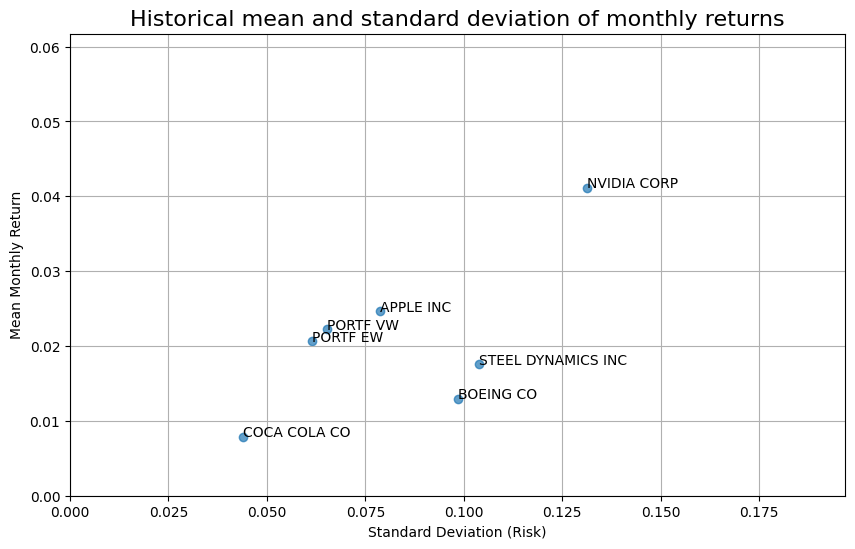

In [ ]:
# Plot assets in risk-return space
plt.figure(figsize=(10, 6))
plt.scatter(return_stats['std_ret'], return_stats['mean_ret'], alpha=0.7)
for i in range(return_stats.shape[0]):
    plt.annotate(return_stats['asset_name'].values[i], (return_stats['std_ret'].values[i], return_stats['mean_ret'].values[i]))
plt.title("Historical mean and standard deviation of monthly returns", fontsize=16)
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Monthly Return")
plt.xlim(0, return_stats['std_ret'].max() * 1.5)
plt.ylim(0, return_stats['mean_ret'].max() * 1.5)
plt.grid()
plt.show()

### Prepare dataset with factor returns and risk-free rate
 - You can find up-to-date factor returns data on the website of Kenneth French:
 https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
 - For this exercise, we will need data on *monthly* Fama/French 5 Factors and Momentum Factor
    1) Fama/French 5 Factors (2x3)
    2) Momentum Factor (Mom)
 - File on Fama/French 5 factors also contains a column for risk-free rate


In [ ]:
# Import FF5 returns data
# Note: careful with skiprows and nrows parameters to get the correct data
# - inspect the CSV file to determine these values
ff5_data = pd.read_csv(path_input / "/content/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, nrows=746)

In [ ]:
ff5_data

,date,mktrf,smb,hml,rmw,cma,rf
0,1963-07-31,-0.39,-0.48,-0.81,0.64,-1.15,0.27
1,1963-08-31,5.08,-0.80,1.70,0.40,-0.38,0.25
2,1963-09-30,-1.57,-0.43,0.00,-0.78,0.15,0.27
3,1963-10-31,2.54,-1.34,-0.04,2.79,-2.25,0.29
4,1963-11-30,-0.86,-0.85,1.73,-0.43,2.27,0.27
...,...,...,...,...,...,...,...
741,2025-04-30,-0.84,-1.86,-3.40,-2.85,-2.67,0.35
742,2025-05-31,6.06,-0.72,-2.88,1.29,2.51,0.38
743,2025-06-30,4.86,-0.02,-1.60,-3.20,1.45,0.34
744,2025-07-31,1.98,-0.15,-1.27,-0.29,-2.08,0.34


In [ ]:
# Rename first column to 'date'
ff5_data.rename(columns={ff5_data.columns[0]: 'date',
                         ff5_data.columns[1]: 'mktrf'}, inplace=True)
# Make all other columns lowercase
ff5_data.columns = [col.lower() for col in ff5_data.columns]
# Convert date to datetime format assuming that the data is valid as of the end of the month
ff5_data['date'] = pd.to_datetime(ff5_data['date'], format='%Y%m') + pd.offsets.MonthEnd(0)


In [ ]:
# Import Momentum factor returns data
# Note: careful with skiprows and nrows parameters to get the correct data
# - inspect the CSV file to determine these values
mom_data = pd.read_csv(path_input / "/content/F-F_Momentum_Factor.csv", skiprows=13, nrows=1184)
mom_data.rename(columns={mom_data.columns[0]: 'date',
                         mom_data.columns[1]: 'mom'}, inplace=True)
# Convert date to datetime format assuming that the data is valid as of the end of the month
mom_data['date'] = pd.to_datetime(mom_data['date'], format='%Y%m') + pd.offsets.MonthEnd(0)

In [ ]:
mom_data

,date,mom
0,1927-01-31,0.57
1,1927-02-28,-1.50
2,1927-03-31,3.52
3,1927-04-30,4.36
4,1927-05-31,2.78
...,...,...
1179,2025-04-30,4.97
1180,2025-05-31,2.21
1181,2025-06-30,-2.64
1182,2025-07-31,-0.96


In [ ]:
# Merge FF5 and Momentum data
factor_data = pd.merge(ff5_data, mom_data, on='date', how='left')

In [ ]:
# Since FF5 data are in percentages, convert them to decimals
factor_data[['mktrf', 'smb', 'hml', 'rmw', 'cma', 'mom', 'rf']] = factor_data[['mktrf', 'smb', 'hml', 'rmw', 'cma','mom', 'rf']] / 100

In [ ]:
factor_data

,date,mktrf,smb,hml,rmw,cma,rf,mom
0,1963-07-31,-0.0039,-0.0048,-0.0081,0.0064,-0.0115,0.0027,0.0101
1,1963-08-31,0.0508,-0.0080,0.0170,0.0040,-0.0038,0.0025,0.0100
2,1963-09-30,-0.0157,-0.0043,0.0000,-0.0078,0.0015,0.0027,0.0012
3,1963-10-31,0.0254,-0.0134,-0.0004,0.0279,-0.0225,0.0029,0.0313
4,1963-11-30,-0.0086,-0.0085,0.0173,-0.0043,0.0227,0.0027,-0.0078
...,...,...,...,...,...,...,...,...
741,2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0035,0.0497
742,2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0038,0.0221
743,2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,0.0034,-0.0264
744,2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,0.0034,-0.0096


In [ ]:
crsp_subset

,permno,date,tsymbol,comnam,prc,ret,vol,shrout,mktcap
0,11308,2009-12-31,KO,COCA COLA CO,57.00000,-0.003497,1928924.0,2317181.0,132.079317
1,11308,2010-01-29,KO,COCA COLA CO,54.25000,-0.048246,1927039.0,2317181.0,125.707069
2,11308,2010-02-26,KO,COCA COLA CO,52.72000,-0.028203,2290196.0,2305124.0,121.526137
3,11308,2010-03-31,KO,COCA COLA CO,55.00000,0.051593,2678707.0,2305124.0,126.781820
4,11308,2010-04-30,KO,COCA COLA CO,53.45000,-0.028182,2219286.0,2307051.0,123.311876
...,...,...,...,...,...,...,...,...,...
902,86580,2024-08-30,NVDA,NVIDIA CORP,119.37000,0.020082,80756836.0,24530000.0,2928.146100
903,86580,2024-09-30,NVDA,NVIDIA CORP,121.44000,0.017425,62413372.0,24530000.0,2978.923200
904,86580,2024-10-31,NVDA,NVIDIA CORP,132.75999,0.093215,56028888.0,24508000.0,3253.681835
905,86580,2024-11-29,NVDA,NVIDIA CORP,138.25000,0.041353,44805933.0,24490000.0,3385.742500


### Merge individual stock data with factor return data

In [ ]:
# Merge on year and month
# - convert date to yearmonth variable
crsp_subset['yearmonth'] = crsp_subset['date'].dt.to_period('M')
factor_data['yearmonth'] = factor_data['date'].dt.to_period('M')

# - perform the merge
crsp_factors = pd.merge(crsp_subset, factor_data.drop(columns=['date']), on='yearmonth', how='left')

In [ ]:
# Compute excess returns for individual stocks
# - denote excess returns as 'retex'
crsp_factors['retex'] = crsp_factors['ret'] - crsp_factors['rf']

In [ ]:
crsp_factors

,permno,date,tsymbol,comnam,prc,ret,vol,shrout,mktcap,yearmonth,mktrf,smb,hml,rmw,cma,rf,mom,retex
0,11308,2009-12-31,KO,COCA COLA CO,57.00000,-0.003497,1928924.0,2317181.0,132.079317,2009-12,0.0274,0.0614,-0.0011,0.0071,-0.0009,0.0001,0.0300,-0.003597
1,11308,2010-01-29,KO,COCA COLA CO,54.25000,-0.048246,1927039.0,2317181.0,125.707069,2010-01,-0.0335,0.0040,0.0033,-0.0108,0.0051,0.0000,-0.0533,-0.048246
2,11308,2010-02-26,KO,COCA COLA CO,52.72000,-0.028203,2290196.0,2305124.0,121.526137,2010-02,0.0339,0.0149,0.0318,-0.0029,0.0142,0.0000,0.0369,-0.028203
3,11308,2010-03-31,KO,COCA COLA CO,55.00000,0.051593,2678707.0,2305124.0,126.781820,2010-03,0.0630,0.0183,0.0219,-0.0061,0.0174,0.0001,0.0357,0.051493
4,11308,2010-04-30,KO,COCA COLA CO,53.45000,-0.028182,2219286.0,2307051.0,123.311876,2010-04,0.0200,0.0496,0.0296,0.0061,0.0175,0.0001,0.0316,-0.028282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,86580,2024-08-30,NVDA,NVIDIA CORP,119.37000,0.020082,80756836.0,24530000.0,2928.146100,2024-08,0.0161,-0.0355,-0.0110,0.0076,0.0082,0.0048,0.0481,0.015282
903,86580,2024-09-30,NVDA,NVIDIA CORP,121.44000,0.017425,62413372.0,24530000.0,2978.923200,2024-09,0.0173,-0.0092,-0.0277,0.0020,-0.0029,0.0040,-0.0062,0.013425
904,86580,2024-10-31,NVDA,NVIDIA CORP,132.75999,0.093215,56028888.0,24508000.0,3253.681835,2024-10,-0.0100,-0.0089,0.0086,-0.0148,0.0098,0.0039,0.0300,0.089315
905,86580,2024-11-29,NVDA,NVIDIA CORP,138.25000,0.041353,44805933.0,24490000.0,3385.742500,2024-11,0.0649,0.0459,0.0015,-0.0231,-0.0205,0.0040,0.0100,0.037353


In [ ]:
# Compute average monthly return, excess return, and standard deviation of returns for individual stocks
return_stats = crsp_factors.groupby('permno').agg(
    mean_ret=('ret', 'mean'),
    mean_retex=('retex', 'mean'),
    std_ret=('ret', 'std')
)

# Add the last comnam for each permno
last_comnam = crsp_factors.groupby('permno')['comnam'].last().reset_index()
return_stats = return_stats.merge(last_comnam, on='permno')
return_stats.columns = ['permno', 'mean_ret', 'mean_retex', 'std_ret', 'asset_name']

In [ ]:
# Construct equally-weighted and value-weighted portfolios
# - ensure data is sorted by date and permno
crsp_factors = crsp_factors.sort_values(by=['date', 'permno'])
# - get lagged market capitalization
crsp_factors['mktcap_l1'] = crsp_factors.groupby('permno')['mktcap'].shift(1)
# - value weighted portfolio weights
crsp_factors['w_vw'] = crsp_factors['mktcap_l1'] / crsp_factors.groupby('date')['mktcap_l1'].transform('sum')
# - equally weighted portfolio weights
crsp_factors['w_ew'] = 1 / crsp_factors.groupby('date')['permno'].transform('count')

In [ ]:
# Compute returns for equally-weighted and value-weighted portfolios
crsp_factors['ret_ew'] = (crsp_factors['ret'] * crsp_factors['w_ew']).groupby(crsp_factors['date']).transform('sum')
crsp_factors['ret_vw'] = (crsp_factors['ret'] * crsp_factors['w_vw']).groupby(crsp_factors['date']).transform('sum')

In [ ]:
# Compute average risk-free rate over the sample period
# Note: the sample period over which the mean and SD was computed in the previous workshop is Jan 2010-Dec 2024
rf_mean_subsample = factor_data[(factor_data['date'] >= "2010-01-01") & (factor_data['date'] <= "2024-12-31")]['rf'].mean()

In [ ]:
# Append portfolio returns to return_stats
# - subset to monthly portfolio returns
portfolio_stats = crsp_factors[(crsp_factors['date'] >= "2010-01-01") & \
                               (crsp_factors['date'] <= "2024-12-31")].groupby('date')[['ret_ew', 'ret_vw']].first().reset_index()
# - compute mean and std dev
ew_mean = portfolio_stats['ret_ew'].mean()
ew_mean_ex = ew_mean - rf_mean_subsample
ew_std = portfolio_stats['ret_ew'].std()
vw_mean = portfolio_stats['ret_vw'].mean()
vw_mean_ex = vw_mean - rf_mean_subsample
vw_std = portfolio_stats['ret_vw'].std()
# - convert into DataFrame
portfolio_summary = pd.DataFrame({
    'mean_ret': [ew_mean, vw_mean],
    'mean_retex': [ew_mean_ex, vw_mean_ex],
    'std_ret': [ew_std, vw_std],
    'asset_name': ['PORTF EW', 'PORTF VW'],
})
# - concatenate along axis 0 (rows)
return_stats = pd.concat([return_stats, portfolio_summary], ignore_index=True)

In [ ]:
print(return_stats)

    permno  mean_ret  mean_retex   std_ret          asset_name
0  11308.0  0.007834    0.006898  0.043756        COCA COLA CO
1  14593.0  0.024786    0.023854  0.078466           APPLE INC
2  19561.0  0.013072    0.012135  0.098328           BOEING CO
3  84262.0  0.017791    0.016855  0.103620  STEEL DYNAMICS INC
4  86580.0  0.043288    0.042334  0.133965         NVIDIA CORP
5      NaN  0.020685    0.019744  0.061563            PORTF EW
6      NaN  0.022269    0.021328  0.065270            PORTF VW


### Compute Sharpe ratios of individual stocks, EW and VW portfolios

In [ ]:
# Compute monthly Sharpe ratios of individual stocks, EW and VW portfolios
return_stats['sharpe_ratio_MON'] = return_stats['mean_retex'] / return_stats['std_ret']

In [ ]:
# Compute annualised Sharpe ratios
return_stats['sharpe_ratio_ANN'] = return_stats['sharpe_ratio_MON'] * np.sqrt(12)

In [ ]:
print(return_stats)

    permno  mean_ret  mean_retex   std_ret          asset_name  \
0  11308.0  0.007834    0.006898  0.043756        COCA COLA CO   
1  14593.0  0.024786    0.023854  0.078466           APPLE INC   
2  19561.0  0.013072    0.012135  0.098328           BOEING CO   
3  84262.0  0.017791    0.016855  0.103620  STEEL DYNAMICS INC   
4  86580.0  0.043288    0.042334  0.133965         NVIDIA CORP   
5      NaN  0.020685    0.019744  0.061563            PORTF EW   
6      NaN  0.022269    0.021328  0.065270            PORTF VW   

   sharpe_ratio_MON  sharpe_ratio_ANN  
0          0.157641          0.546086  
1          0.304001          1.053090  
2          0.123417          0.427530  
3          0.162662          0.563477  
4          0.316011          1.094693  
5          0.320711          1.110975  
6          0.326771          1.131968  


### Annualised Sharpe: Example of Fidelity Magellan Fund
https://fundresearch.fidelity.com/mutual-funds/performance-and-risk/316184100
 - Compare the Sharpe of Fidelity Magellan Fund to that of stocks/portfolios in our sample?
    - under what assumption(s)?
 - What is Fidelity Magellan's:
    - primary benchmark?
    - Morningstar category?
    - measures of total, systematic, and idiosyncratic risk?

### Summary statistics of factor returns

For each factor:
 - compute average realised monthly return and its standard deviation
 - cumulative monthly return

Focus on sample period between Jan 1970 and Dec 2024 (inclusive).

In [ ]:
# Compute mean and standard deviation of returns for each factor
factor_stats = factor_data[(factor_data['date'] >= "1970-01-01") & (factor_data['date'] <= "2024-12-31")].agg({
    'mktrf': ['mean', 'std'],
    'smb': ['mean', 'std'],
    'hml': ['mean', 'std'],
    'rmw': ['mean', 'std'],
    'cma': ['mean', 'std'],
    'mom': ['mean', 'std']
}).T.reset_index().rename(columns={'index': 'factor'})

print(factor_stats)

  factor      mean       std
0  mktrf  0.006116  0.045946
1    smb  0.001223  0.030445
2    hml  0.002920  0.030751
3    rmw  0.003012  0.022772
4    cma  0.002893  0.020597
5    mom  0.005701  0.043311


In [ ]:
# Compute correlations between factor returns
factor_returns_aux = factor_data[(factor_data['date'] >= "1970-01-01") & (factor_data['date'] <= "2024-12-31")][['mktrf', 'smb', 'hml', 'rmw', 'cma', 'mom']]
factor_correlation = factor_returns_aux.corr()
print(factor_correlation)

          mktrf       smb       hml       rmw       cma       mom
mktrf  1.000000  0.258894 -0.213800 -0.199050 -0.361695 -0.195169
smb    0.258894  1.000000  0.007232 -0.372067 -0.064552 -0.113252
hml   -0.213800  0.007232  1.000000  0.121204  0.691349 -0.185622
rmw   -0.199050 -0.372067  0.121204  1.000000  0.045409  0.076092
cma   -0.361695 -0.064552  0.691349  0.045409  1.000000  0.021304
mom   -0.195169 -0.113252 -0.185622  0.076092  0.021304  1.000000


In [ ]:
# Compute cumulative returns for each factor and risk-free rate using Dec 1969 as base month
# - subset relevant period
factor_data_cumul = factor_data[(factor_data['date'] >= "1969-12-01") & (factor_data['date'] <= "2024-12-31")].copy()

# - compute gross returns
factor_names = ['mktrf', 'smb', 'hml', 'rmw', 'cma', 'mom']
for name in factor_names:
    factor_data_cumul[name + '_gross'] = 1 + factor_data_cumul[name].fillna(0)
# - ensure that data is sorted by date
factor_data_cumul = factor_data_cumul.sort_values(by='date').reset_index(drop=True)
# - set the first observation to be the initial investment of 1 USD
for name in factor_names:
    factor_data_cumul.loc[factor_data_cumul['date'] == '1969-12-31', name + '_gross'] = 1
# - compute cumulative returns
for name in factor_names:
    factor_data_cumul[name + '_cumul'] = factor_data_cumul[name + '_gross'].cumprod()

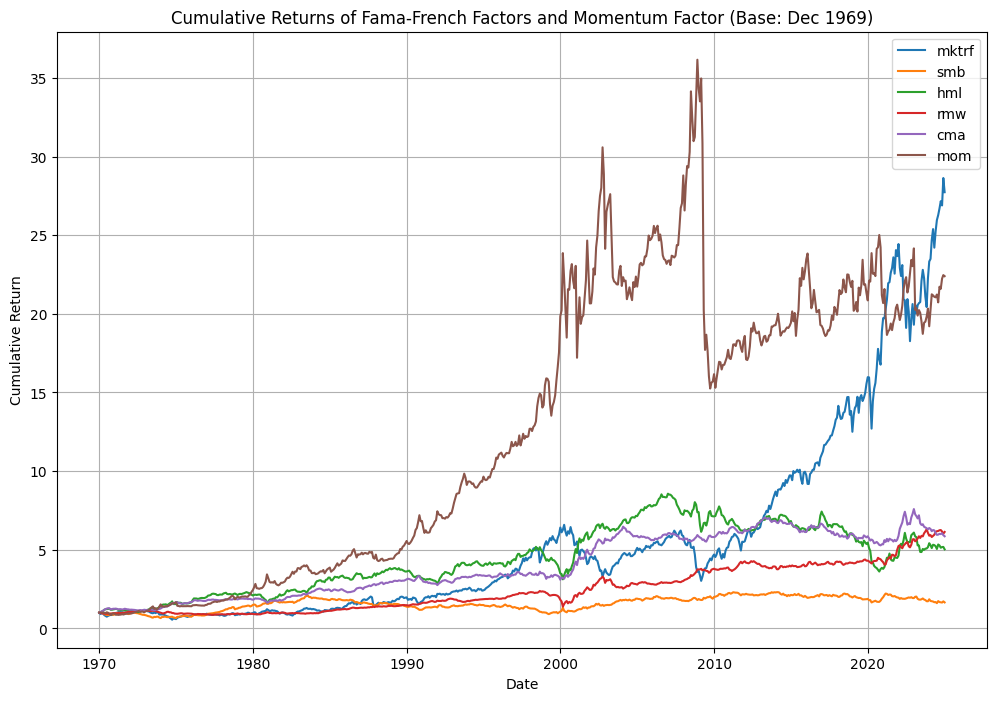

In [ ]:
# Plot cumulative returns for each factor & risk-free rate
data_plot = factor_data_cumul[(factor_data_cumul['date'] >= "1969-12-01") & (factor_data_cumul['date'] <= "2024-12-31")].copy()
plt.figure(figsize=(12, 8))
for name in factor_names:
    plt.plot(data_plot['date'], data_plot[name + '_cumul'], label=name)
plt.title('Cumulative Returns of Fama-French Factors and Momentum Factor (Base: Dec 1969)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()

 - Momentum crashes:
Daniel, K., & Moskowitz, T. J. (2016). Momentum crashes. Journal of Financial Economics, 122(2), 221–247. https://doi.org/10.1016/j.jfineco.2015.12.002

### Sharpe ratios of factor returns

In [ ]:
# Compute Sharpe ratios of factor returns
factor_stats['sharpe_ratio_MON'] = factor_stats['mean'] / factor_stats['std']
factor_stats['sharpe_ratio_ANN'] = factor_stats['sharpe_ratio_MON'] * np.sqrt(12)
print(factor_stats)

  factor      mean       std  sharpe_ratio_MON  sharpe_ratio_ANN
0  mktrf  0.006116  0.045946          0.133112          0.461113
1    smb  0.001223  0.030445          0.040162          0.139124
2    hml  0.002920  0.030751          0.094961          0.328956
3    rmw  0.003012  0.022772          0.132272          0.458202
4    cma  0.002893  0.020597          0.140445          0.486514
5    mom  0.005701  0.043311          0.131620          0.455946


### Estimation of Factor Models

#### Timeline of the development of modern multi-factor models:

 - (1973) Empirical tests of CAPM

 Fama, E. F., & MacBeth, J. D. (1973). Risk, Return, and Equilibrium: Empirical Tests. Journal of Political Economy, 81(3), 607–636. http://www.jstor.org/stable/1831028

 - (1993) Fama-French 3-factor model was proposed in:

Fama, E. F., & French, K. R. (1993). Common risk factors in the returns on stocks and bonds. Journal of Financial Economics, 33(1), 3–56. https://doi.org/10.1016/0304-405X(93)90023-5

 - (1993) Momentum factor was proposed by:

Jegadeesh, N., & Titman, S. (1993). Returns to buying winners and selling losers: Implications for stock market efficiency. The Journal of Finance, 48(1), 65–91. https://doi.org/10.1111/j.1540-6261.1993.tb04702.x

 - (1997) Carhart 4-factor model (Fama-French 3-factor + Momentum) was proposed in:

Carhart, M. M. (1997). On persistence in mutual fund performance. The Journal of Finance, 52(1), 57–82. https://doi.org/10.1111/j.1540-6261.1997.tb03808.x

 - (2015) Fama-French 5-factor model was proposed in:

Fama, E. F., & French, K. R. (2015). A five-factor asset pricing model. Journal of Financial Economics, 116(1), 1–22. https://doi.org/10.1016/j.jfineco.2014.10.010

 - (2023) Modern studies with <span style="color:red;">*parsimonious*</span> multi-factor models use so-called Fama-French 6-factor model which is FF5 + Momentum. See, for example:

Detzel, A., Novy-Marx, R., & Velikov, M. (2023). Model comparison with transaction costs. The Journal of Finance, 78(2), 665–708. https://doi.org/10.1111/jofi.13225

In [ ]:
# Import libraries needed for linear regression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [ ]:
# Print unique permnos with last comnam
unique_permnos = crsp_factors[['permno', 'comnam']].drop_duplicates()
print(unique_permnos)

     permno              comnam
0     11308        COCA COLA CO
181   14593           APPLE INC
363   19561           BOEING CO
544   84262  STEEL DYNAMICS INC
725   86580         NVIDIA CORP


#### CAPM

In [ ]:
# Run a linear regression via statsmodels
# - select one stock for the regression (since we are running time-series regression)
reg_data = crsp_factors[crsp_factors['permno'] == 11308]
# - drop rows with missing values
reg_data = reg_data.dropna(subset=['retex','mktrf'])

# Define dependent and independent variables
X = add_constant(reg_data['mktrf'])
y = reg_data['retex']
print(X.shape)
print(y.shape)

# Fit the OLS regression
# - compute Newey-West standard errors with automatic lag selection
model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': None})
# - under i.i.d. errors:
# model = OLS(y, X).fit()

# Print the regression results summary
print(model.summary())

(181, 2)
(181,)
                            OLS Regression Results                            
Dep. Variable:                  retex   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     35.57
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           1.28e-08
Time:                        21:46:22   Log-Likelihood:                 332.57
No. Observations:                 181   AIC:                            -661.1
Df Residuals:                     179   BIC:                            -654.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003    

### Fama-French 6-factor model

In [ ]:
# Run a linear regression via statsmodels
# - select one stock for the regression (since we are running time-series regression)
reg_data = crsp_factors[crsp_factors['permno'] == 11308]
# - drop rows with missing values
reg_data = reg_data.dropna(subset=['retex','mktrf','smb','hml','rmw','cma','mom'])

# Define dependent and independent variables
X = add_constant(reg_data[['mktrf','smb','hml','rmw','cma','mom']])
y = reg_data['retex']
print(X.shape)
print(y.shape)

# Fit the OLS regression
# - compute Newey-West standard errors with automatic lag selection
model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': None})
# - under i.i.d. errors:
# model = OLS(y, X).fit()

# Print the regression results summary
print(model.summary())

(181, 7)
(181,)
                            OLS Regression Results                            
Dep. Variable:                  retex   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     28.48
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           1.40e-23
Time:                        21:46:31   Log-Likelihood:                 359.66
No. Observations:                 181   AIC:                            -705.3
Df Residuals:                     174   BIC:                            -682.9
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.002    